In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules import padding

%pip install torchmetrics
from torchmetrics.classification import BinaryF1Score

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 8.2 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path ='/content/drive/MyDrive/project_images/train/class1/img (1).jpg'

img = Image.open(path)
npimg = np.array(img)
print(npimg.shape)

(1920, 1080, 3)


In [3]:
#Define transformations
height = 256
width = 154
pad = torchvision.transforms.Compose([torchvision.transforms.Resize((height, width)), 
                                      torchvision.transforms.Pad(5), 
                                      torchvision.transforms.ToTensor(),
                                      torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#Load datasets

train_path = '/content/drive/MyDrive/project_images/train'
train_dataset = torchvision.datasets.ImageFolder(root=train_path, transform=pad)

test_path = '/content/drive/MyDrive/project_images/test'
test_dataset = torchvision.datasets.ImageFolder(root=test_path, transform=pad)

#Load dataloaders

train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=4)

test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=4)

#Define classes
classes = ('nonflip', 'flip')

In [4]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 2392
    Root location: /content/drive/MyDrive/project_images/train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 154), interpolation=bilinear, max_size=None, antialias=None)
               Pad(padding=5, fill=0, padding_mode=constant)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [5]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 597
    Root location: /content/drive/MyDrive/project_images/test
    StandardTransform
Transform: Compose(
               Resize(size=(256, 154), interpolation=bilinear, max_size=None, antialias=None)
               Pad(padding=5, fill=0, padding_mode=constant)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

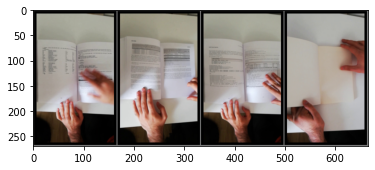

In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [7]:
images, labels = next(dataiter)
images[0].shape

nonflip nonflip nonflip nonflip


torch.Size([3, 266, 164])

In [8]:
#Define nn
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(38304, 4)
        self.fc2 = nn.Linear(4, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [9]:
#Define error function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


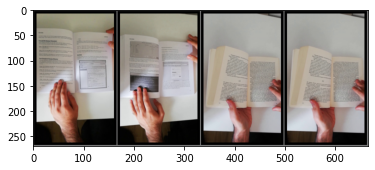

GroundTruth:  nonflip nonflip nonflip nonflip


In [11]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [12]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  nonflip nonflip nonflip nonflip


In [16]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct // total} %')

Accuracy: 88 %


In [17]:
preds = []
target = []

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        preds.append(int(predicted[0]))
        target.append(int(labels[0]))
        
preds = torch.tensor(preds)
target = torch.tensor(target)
metric = BinaryF1Score()
f1 = metric(preds, target)
f1 = float(f1)

print(f'F1 Score: {f1}')

F1 Score: 0.8873239159584045
